In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
raw_data = pd.read_csv('mnist_train.csv')

In [34]:
images = raw_data.iloc[:,1:].values
images = images.astype(float)
images = np.multiply(images, 1.0/255.0)
size = int(np.sqrt(len(images[0])))
images = [img.reshape((size, size)) for img in images]

labels = raw_data.iloc[:,0].values
print(labels[1])

4


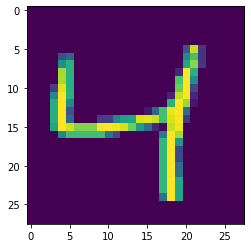

In [31]:
plt.imshow(images[1])

### Cool, so our images are 28x28x1 arrays. This should be a little easier than RGB.

Let's just rebuild our CNN from scratch

In [95]:
class ConvLayer:
    def __init__(self, num_filters, filter_size, strides=1):
        self.num_filters = num_filters
        self.strides = strides
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / (filter_size*filter_size)
        
    def patch_generator(self, image):
        height, width = image.shape
        self.image = image
        
        out_height, out_width, num_filters = self.out_size
        
        # iterate over image, yielding patches as we go
        for i in range(out_height):
            for j in range(out_width):
                image_patch = image[i:i+self.filter_size, j:j+self.filter_size]
                yield image_patch, i, j
                
    
    def forward_prop(self, image):
        height, width = image.shape
        self.out_size = (int((height - self.filter_size) / self.strides + 1), int((width - self.filter_size) / self.strides + 1), self.num_filters)
        conv_out = np.zeros(self.out_size)
        
        for image_patch, i, j in self.patch_generator(image):
            conv_out[i, j] = np.sum(image_patch * self.filters, axis=(1,2))
        
        return conv_out
    
    
    def backward_prop(self, dL_dout, learning_rate):
        dL_dW_params = np.zeros(self.filters.shape)
        
        for image_patch, i, j in self.patch_generator(self.image):
            for f in range(self.num_filters):
                dL_dW_params[f] += image_patch * dL_dout[i,j,f]
            
        self.filters -= learning_rate*dL_dW_params
        
        return dL_dW_params
    


In [96]:
# Quick forward propagation test

D = ConvLayer(num_filters=4, filter_size=2)
out = D.forward_prop(images[0])
print(out.shape)

(27, 27, 4)


In [97]:
class MaxPoolLayer:
    def __init__(self, filter_size):
        self.filter_size = filter_size
        
    def patch_generator(self, image):
        self.image = image
        out_height, out_width, out_depth = self.out_size
        
        for i in range(out_height):
            for j in range(out_width):
                image_patch = image[(i*self.filter_size):(self.filter_size*(i+1)), (j*self.filter_size):(self.filter_size*(j+1))]
                yield image_patch, i, j
        
    def forward_prop(self, image):
        inp_height, inp_width, inp_num_filters = image.shape
        self.out_size = ((inp_height // self.filter_size), (inp_width // self.filter_size), inp_num_filters)
        out = np.zeros(self.out_size)
        
        for patch, i, j in self.patch_generator(image):
            out[i, j] = np.amax(patch, axis=(0,1))
        
        return out
    
    def backward_prop(self, dL_dout):
        dL_dMP = np.zeros(self.image.shape)
        
        for patch, i, j in self.patch_generator(self.image):
            ph, pw, pf = patch.shape
            max_val = np.amax(patch, axis=(0,1))
            
            # Here we only want the gradient that corresponds to the
            # maximum value from the input image to be updated
        
            for h in range(ph):
                for w in range(pw):
                    for f in range(pf):
                        if patch[h,w,f] == max_val[f]:
                            dL_dMP[i*self.filter_size + h, j*self.filter_size + w, f] = dL_dout[i,j,f]
            
            return dL_dMP
            

In [98]:
# Test out forward prop thru maxpool
MP = MaxPoolLayer(2)
mp_out = MP.forward_prop(out)
print(mp_out.shape)

(13, 13, 4)


In [136]:
class SoftmaxLayer:
    def __init__(self, num_inputs, num_classes):
        self.weights = np.random.randn(num_inputs, num_classes) / num_inputs
        self.biases = np.zeros(num_classes)
        
        
    def forward_prop(self, image):
        self.orig_img_shape = image.shape
        flattened = image.flatten()
        self.flattened = flattened
        out = np.dot(flattened, self.weights) + self.biases
        print('weights: ', self.weights)
        print('flattened: ', max(self.flattened))
        self.out = out
        exp_out = np.exp(out)
        
        return exp_out / np.sum(exp_out, axis=0)
    
    def backward_prop(self, dL_dout, learning_rate):
        
        # The gradient here will be the -log of our predicted y
        # The rest of the values will be 0
        for i, gradient in enumerate(dL_dout):
            if gradient == 0:
                continue
                
            exp = np.exp(self.out)
            S_total = np.sum(exp)
            
            # case 2: i != l
            dy_dz = -exp[i] * exp / (S_total**2)
            
            # case 1: i == l (this is equiv. to y*(1-y))
            dy_dz[i] = exp[i]*(S_total - exp[i]) / (S_total**2)
            
            # dz_dw, dz_db, dz_dinput
            dz_dw = self.flattened
            dz_db = 1
            dz_dinput = self.weights
            
            # grad is dL_dy
            # dL/dz = dL/dy * dy/dz
            dL_dz = gradient * dy_dz
            
            # loss wrt. weights, biases, input
            dL_dW = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_dinput = dz_dinput @ dL_dz
            
            # update weights and biases
            self.weights = self.weights - (learning_rate * dL_dW)
            self.biases = self.biases - (learning_rate * dL_db)
            
            return dL_dinput.reshape(self.orig_img_shape)
            

In [137]:
from math import prod

SM = SoftmaxLayer(num_inputs=prod(mp_out.shape), num_classes=10)
sm_out = SM.forward_prop(mp_out)
print(sm_out)

weights:  [[ 6.84303229e-04  1.44703948e-03 -1.16748854e-03 ... -1.23821602e-04
  -1.64395162e-03 -3.19932154e-04]
 [-1.79169757e-04 -1.65434911e-03  5.48089663e-04 ...  2.44365151e-03
  -2.47236430e-03 -4.30287478e-04]
 [-8.72104268e-04  7.90317671e-04 -1.55832210e-03 ...  3.30992212e-03
  -8.16545437e-04 -2.62090024e-03]
 ...
 [-6.41925388e-05  1.60459125e-03 -9.36936180e-04 ...  1.15351315e-04
  -2.64329546e-03 -2.95264567e-04]
 [ 3.14744620e-03  3.05515387e-03  9.07607368e-04 ... -2.52507586e-04
  -6.88837519e-04  2.53991509e-04]
 [-1.25431818e-03 -1.61185409e-03  4.65730916e-05 ... -5.44517571e-04
  -1.23283158e-03  4.59909462e-04]]
flattened:  0.7126646951180666
[0.09968671 0.09895606 0.09914998 0.10012274 0.09967732 0.09996651
 0.10063664 0.10087747 0.10109838 0.09982817]


## This softmax output is promising
This is actually way more promising than the CIFAR CNN at this stage

The output of the softmax *should* look like this (approx. equal probabilities because we have done zero training), and on the CIFAR it looked far more random than this.

So maybe I have something wrong with my forward propagation on the other attempt.

In [104]:
# Moment of truth: backpropagation

image_label = labels[0]
num_classes = 10
learning_rate = 0.005

# Cross-entropy-loss
def initial_gradient (sm_out, image_label):
    cross_entropy_loss = -np.log(sm_out[image_label])
    acc = 1 if np.argmax(sm_out) == image_label else 0

    gradient = np.zeros(num_classes)
    gradient[image_label] = -1 / sm_out[image_label]
    
    return gradient

gradient = initial_gradient(sm_out, image_label)

gradient = SM.backward_prop(gradient, learning_rate)
print(gradient.shape)
gradient = MP.backward_prop(gradient)
print(gradient.shape)
gradient = D.backward_prop(gradient, learning_rate)
print(gradient.shape)

(13, 13, 4)
(27, 27, 4)
(4, 2, 2)


In [105]:
# Second moment of truth: feeding in a 2nd image

img2 = images[2]
label = labels[2]

fwd = D.forward_prop(img2)
fwd = MP.forward_prop(fwd)
fwd = SM.forward_prop(fwd)
print(fwd)

gradient = initial_gradient(fwd, label)

back = SM.backward_prop(gradient, learning_rate)
back = MP.backward_prop(back)
back = D.backward_prop(back, learning_rate)
print(back.shape)

[0.10845248 0.09911881 0.09891256 0.09832081 0.09943338 0.09930509
 0.09901739 0.09955113 0.09907859 0.09880976]
(4, 2, 2)


### Alright! No real change but no exploding/vanishing gradient immediately, so we'll train on many images and see what happens

In [128]:
# This is partly reused code from cnn_cifar.ipynb

class CNNModel:
    def __init__(self, layers, num_classes, learning_rate=0.005):
        assert len(layers) >= 1
        self.layers = layers
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        
    def forward_prop(self, image, label):
        out_forward = self.layers[0].forward_prop(image)
        for layer in self.layers[1:]:
            out_forward = layer.forward_prop(out_forward)
        
        cross_entropy_loss = -np.log(out_forward[label])
        accuracy = 0
        if np.argmax(out_forward) == label:
            accuracy = 1
        
        return out_forward, cross_entropy_loss, accuracy
    
    def backward_prop(self, initial_gradient):
        back_gradient = self.layers[-1].backward_prop(initial_gradient, self.learning_rate)
        for layer in reversed(self.layers[:-1]):
            if isinstance(layer, MaxPoolLayer):
                back_gradient = layer.backward_prop(back_gradient)
            else:
                back_gradient = layer.backward_prop(back_gradient, self.learning_rate)
    
    def train_image(self, image, label):
        
        # Forward propagation
        out_fw, loss, acc = self.forward_prop(image, label)
        # calc initial gradient
        gradient = np.zeros(self.num_classes)
        gradient[label] = -1 / out_fw[label]
        
        # Backward propagation
        self.backward_prop(gradient)
        
        return loss, acc
    
    def train(self, images, labels):
        loss = 0
        num_correct = 0
        for i, (img, label) in enumerate(zip(images, labels)):
            if i % 100 == 0:
                print('after {num} images, loss={loss} and correct%={correct}'.format(num=i, loss=loss, correct=(num_correct/100)))
                loss = 0
                num_correct = 0
            
            l, a = self.train_image(img, label)
            loss += l
            num_correct += a

model_test = CNNModel(
    layers=[
        ConvLayer(num_filters=4, filter_size=4),
        MaxPoolLayer(2),
        SoftmaxLayer(num_inputs=12*12*4, num_classes=10)
    ],
    num_classes=10,
    learning_rate=0.005
)

In [129]:
loss, acc = model_test.train_image(images[0], labels[0])
print(loss, acc)

2.2977086246321594 0


In [130]:
# Let's set up some training and testing data
# images contains 59999 images

train_set = images[:50000]
train_labels = labels[:50000]

test_set = images[50000:]
test_labels = labels[50000:]

In [131]:
# Now let's train

model_test.train(train_set, train_labels)

after 0 images, loss=0 and correct%=0.0
after 100 images, loss=228.3322244196201 and correct%=0.24
after 200 images, loss=225.04558837957137 and correct%=0.39
after 300 images, loss=221.38681538148006 and correct%=0.61
after 400 images, loss=217.95629460391243 and correct%=0.7
after 500 images, loss=215.53734498392126 and correct%=0.66
after 600 images, loss=215.22334798557947 and correct%=0.62
after 700 images, loss=212.89179814884645 and correct%=0.57
after 800 images, loss=208.11056613934628 and correct%=0.68
after 900 images, loss=204.4946800137935 and correct%=0.74
after 1000 images, loss=202.4850617697718 and correct%=0.72
after 1100 images, loss=202.459564266516 and correct%=0.64
after 1200 images, loss=199.02742862307858 and correct%=0.69
after 1300 images, loss=200.73122771723723 and correct%=0.6
after 1400 images, loss=192.1860624180741 and correct%=0.76
after 1500 images, loss=191.63238915680824 and correct%=0.74
after 1600 images, loss=190.35865869084572 and correct%=0.74
a

after 13600 images, loss=64.52985843619761 and correct%=0.87
after 13700 images, loss=89.36801656512986 and correct%=0.79
after 13800 images, loss=89.48932547716748 and correct%=0.81
after 13900 images, loss=82.91909002006008 and correct%=0.85
after 14000 images, loss=98.75874745639555 and correct%=0.71
after 14100 images, loss=87.0757994410113 and correct%=0.82
after 14200 images, loss=88.82819481238245 and correct%=0.79
after 14300 images, loss=97.05676843600148 and correct%=0.79
after 14400 images, loss=102.37598907585084 and correct%=0.73
after 14500 images, loss=83.96984252364865 and correct%=0.82
after 14600 images, loss=91.41000566819946 and correct%=0.8
after 14700 images, loss=116.20923004833521 and correct%=0.68
after 14800 images, loss=110.29323085906505 and correct%=0.69
after 14900 images, loss=84.8548391881998 and correct%=0.82
after 15000 images, loss=80.67792954074325 and correct%=0.85
after 15100 images, loss=69.13578689318726 and correct%=0.9
after 15200 images, loss=

after 27100 images, loss=57.09724421584202 and correct%=0.89
after 27200 images, loss=75.47215708964211 and correct%=0.81
after 27300 images, loss=63.00918387373591 and correct%=0.87
after 27400 images, loss=60.44009598588798 and correct%=0.88
after 27500 images, loss=64.37813284586906 and correct%=0.83
after 27600 images, loss=54.8669945354856 and correct%=0.9
after 27700 images, loss=66.87799634999176 and correct%=0.86
after 27800 images, loss=64.01620647601224 and correct%=0.89
after 27900 images, loss=59.00621856650822 and correct%=0.88
after 28000 images, loss=51.9716618118747 and correct%=0.89
after 28100 images, loss=42.167993476505515 and correct%=0.94
after 28200 images, loss=66.91205090651825 and correct%=0.86
after 28300 images, loss=53.266167240143616 and correct%=0.89
after 28400 images, loss=70.8606789944171 and correct%=0.85
after 28500 images, loss=49.99057119344097 and correct%=0.92
after 28600 images, loss=58.53130351329503 and correct%=0.87
after 28700 images, loss=8

after 40600 images, loss=58.33109942251253 and correct%=0.88
after 40700 images, loss=50.83892677763641 and correct%=0.88
after 40800 images, loss=48.98101541325639 and correct%=0.92
after 40900 images, loss=45.69614328412838 and correct%=0.9
after 41000 images, loss=44.76801352090879 and correct%=0.91
after 41100 images, loss=60.325640440064426 and correct%=0.84
after 41200 images, loss=53.154674615515994 and correct%=0.85
after 41300 images, loss=61.449842062569665 and correct%=0.84
after 41400 images, loss=74.19612596618076 and correct%=0.84
after 41500 images, loss=72.38345239269428 and correct%=0.81
after 41600 images, loss=70.13338352725978 and correct%=0.81
after 41700 images, loss=51.96430788566771 and correct%=0.89
after 41800 images, loss=56.72145253985029 and correct%=0.87
after 41900 images, loss=47.67154814457865 and correct%=0.92
after 42000 images, loss=52.70447629007874 and correct%=0.88
after 42100 images, loss=48.7920479226588 and correct%=0.88
after 42200 images, los